In [1]:
import random
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow import optimizers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import scipy
import warnings
from vit_keras import vit
from vit_keras.vit import vit_b16
warnings.filterwarnings("ignore") 


#训练样本的目录
train_dir='./NewThree_Dataset/train'
#验证样本的目录
validation_dir='./NewThree_Dataset/val'
#测试样本目录
test_dir='./NewThree_Dataset/test'

2025-05-29 21:46:25.243416: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above

In [2]:
#训练集生成器---训练集数据加强
train_datagen=ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224,224),
    batch_size=32
)
 
#验证样本生成器
validation_datagen=ImageDataGenerator(rescale=1./255)
validation_generator=validation_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(224,224),
    batch_size=32
)
 
#测试样本生成器
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=False
)
print(train_generator.class_indices)
print(test_generator.class_indices)
print(validation_generator.class_indices)

Found 4189 images belonging to 3 classes.
Found 1150 images belonging to 3 classes.
Found 1267 images belonging to 3 classes.
{'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2}
{'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2}
{'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2}


In [3]:
# 加载预训练 ViT 模型, 设置 include_top=False，预训练顶层为 False
vit_model = vit.vit_b16(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=3
)

# 打印模型结构
vit_model.summary()


2025-05-29 21:46:28.526144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-29 21:46:29.101675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input   (None, 197, 768)         151296    
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 197, 768),       7087872   
 (TransformerBlock)           (None, 12, None, None))      

In [4]:
# 构建自定义模型结构
model = models.Sequential()
model.add(vit_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

# 确保所有层是可训练的
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

# 转换为推理图
model_function = tf.function(lambda inputs: model(inputs))
concrete_function = model_function.get_concrete_function(tf.TensorSpec([1, 224, 224, 3], model.inputs[0].dtype))

# 转换模型为静态图
frozen_func = convert_variables_to_constants_v2(concrete_function)

# 获取模型的图定义
graph = frozen_func.graph

# 使用 TensorFlow 1.x 中的 profiler 计算 FLOPs
with tf.compat.v1.Session(graph=graph) as sess:
    flops = tf.compat.v1.profiler.profile(
        graph=sess.graph,
        options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    )
    print('FLOPs: {}'.format(flops.total_float_ops))

2025-05-29 21:46:33.992967: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-05-29 21:46:33.993199: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2025-05-29 21:46:34.000241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


2025-05-29 21:46:39.891567: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:56:00.0, compute capability: 8.6



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implementation for the math behind it.

Profi

In [5]:
# 清理session以释放内存
tf.keras.backend.clear_session()

ansformer/encoderblock_8/LayerNorm_2/moments/variance (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_8/MlpBlock_3/Transformer/encoderblock_8/Dense_1/BiasAdd (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_8/MultiHeadDotProductAttention_1/key/BiasAdd (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_8/MultiHeadDotProductAttention_1/out/BiasAdd (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_8/MultiHeadDotProductAttention_1/query/BiasAdd (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_8/MultiHeadDotProductAttention_1/value/BiasAdd (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_9/LayerNorm_0/batchnorm/mul (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_9/LayerNorm_0/batchnorm/mul_1 (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/encoderblock_9/LayerNorm_0/batchnorm/mul_2 (151.30k/151.30k flops)
  sequential/vit-b16/Transformer/e

In [6]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

In [7]:
#设置 EarlyStopping 回调
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#设置 ReduceLROnPlateau 回调
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=1e-6)

# 训练模型
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

#保存模型
model.save('.AD/ViT-1.h5')

# 评估测试集的准确率
test_eval = model.evaluate_generator(test_generator)
print("测试集准确率：", test_eval)
train_eval = model.evaluate_generator(train_generator)
print("训练集准确率：", train_eval)
val_eval = model.evaluate_generator(validation_generator)
print("验证集准确率：", val_eval)

Epoch 1/100


2025-05-29 21:46:53.256768: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-05-29 21:46:54.859558: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


130/130 [==============================] - 57s 334ms/step - loss: 1.3396 - acc: 0.5295 - val_loss: 1.1295 - val_acc: 0.6036 - lr: 1.0000e-04
Epoch 2/100
130/130 [==============================] - 41s 312ms/step - loss: 1.1082 - acc: 0.6161 - val_loss: 1.0561 - val_acc: 0.6384 - lr: 1.0000e-04
Epoch 3/100
130/130 [==============================] - 41s 312ms/step - loss: 0.9167 - acc: 0.7544 - val_loss: 0.7507 - val_acc: 0.8223 - lr: 1.0000e-04
Epoch 4/100
130/130 [==============================] - 41s 313ms/step - loss: 0.7969 - acc: 0.8076 - val_loss: 0.7413 - val_acc: 0.8482 - lr: 1.0000e-04
Epoch 5/100
130/130 [==============================] - 41s 314ms/step - loss: 0.6475 - acc: 0.8797 - val_loss: 0.6950 - val_acc: 0.8571 - lr: 1.0000e-04
Epoch 6/100
130/130 [==============================] - 41s 314ms/step - loss: 0.5102 - acc: 0.9322 - val_loss: 0.4695 - val_acc: 0.9446 - lr: 1.0000e-04
Epoch 7/100
130/130 [==============================] - 41s 312ms/step - loss: 0.4561 - acc: 0.

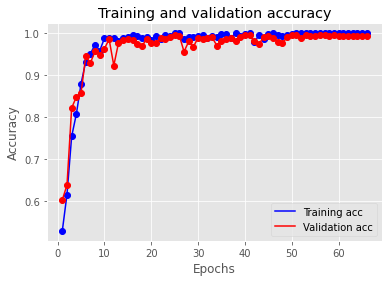

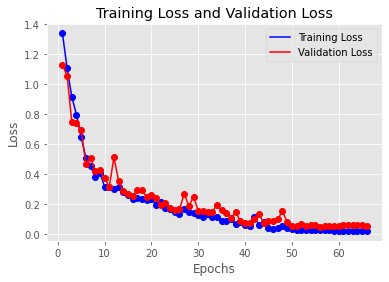

In [8]:
plt.style.use('ggplot')
#绘制训练过程中的损失曲线和精度曲线
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs,val_acc, 'ro')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, loss,'b', label ='Training Loss')
plt.plot(epochs, val_loss,'ro')
plt.plot(epochs, val_loss,'r',label='Validation Loss')
 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss and Validation Loss")
plt.legend()

40/40 [==============================] - 7s 105ms/step


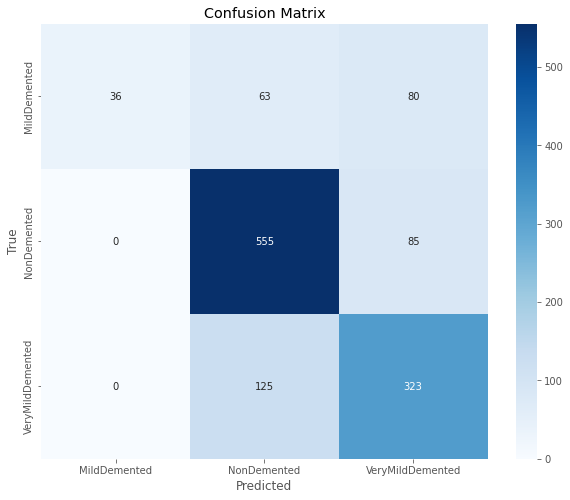

Classification Report
                  precision    recall  f1-score   support

    MildDemented       1.00      0.20      0.33       179
     NonDemented       0.75      0.87      0.80       640
VeryMildDemented       0.66      0.72      0.69       448

        accuracy                           0.72      1267
       macro avg       0.80      0.60      0.61      1267
    weighted avg       0.75      0.72      0.70      1267



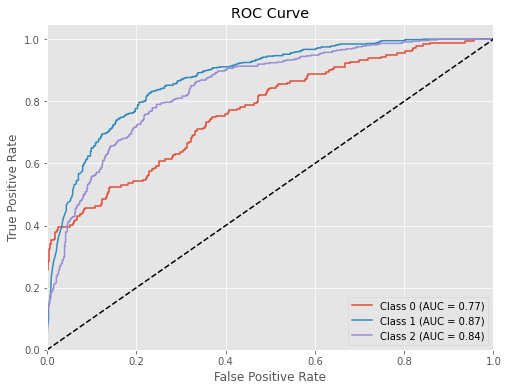

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from keras.utils import to_categorical
import numpy as np

from keras.models import load_model

model = models.load_model('.AD/ViT-1.h5')

# 获取预测值和真实标签
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# 混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 可视化混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 分类报告
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

# 定义类别数量
num_classes = 3 

# 转换真实标签为二进制格式
y_true_binary = to_categorical(y_true, num_classes=num_classes)

# 绘制AUC曲线
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()